In [31]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import interpolate, optimize
from scipy.stats import norm
from scipy.optimize import minimize

# Getting risk-free rates
### Step1: Get risk-free rate from spot yield curve.
### Step2: Transform the curve to continuously compounded yield curve.
### Step3: Use cubic spline to interpolate points in between the points given in the reference.

Reference of spot rates: https://www.gurufocus.com/yield_curve.php

In [138]:
# The spot curve in Sep 2023
yield_curves = pd.DataFrame({'T[days]': [30, 90, 180, 365, 365*2, 365*3, 365*5, 365*7, 365*10],
                'Spot rate (semi annually compounded)' : [0.0555, 0.0555, 0.0553, 0.0546, 
                                                          0.0503, 0.048, 0.046, 0.0461, 0.0459]
               })

yield_curves['Spot rate (continuously compounded)'] = 2*np.log(1 + yield_curves['Spot rate (semi annually compounded)']/2)
yield_curves['T[years]'] = yield_curves['T[days]']/365
yield_curves

,T[days],Spot rate (semi annually compounded),Spot rate (continuously compounded),T[years]
0,30,0.0555,0.054744,0.082192
1,90,0.0555,0.054744,0.246575
2,180,0.0553,0.054549,0.493151
3,365,0.0546,0.053868,1.000000
4,730,0.0503,0.049678,2.000000
5,1095,0.0480,0.047433,3.000000
6,1825,0.0460,0.045479,5.000000
7,2555,0.0461,0.045577,7.000000
8,3650,0.0459,0.045381,10.000000


In [139]:
cubic_spline_function = CubicSpline(yield_curves['T[years]'], yield_curves['Spot rate (continuously compounded)'], bc_type='natural')
cubic_spline_T = np.linspace(0, 10, 500)
interpolated_yield = cubic_spline_function(cubic_spline_T)
interpolated_yield

array([0.0547335 , 0.05473491, 0.05473726, 0.05474024, 0.05474355,
       0.05474689, 0.05474996, 0.05475246, 0.05475409, 0.05475454,
       0.05475352, 0.05475071, 0.05474584, 0.05473861, 0.05472908,
       0.05471749, 0.05470409, 0.05468912, 0.05467282, 0.05465544,
       0.05463721, 0.05461839, 0.05459921, 0.05457992, 0.05456077,
       0.05454198, 0.05452365, 0.05450565, 0.05448785, 0.05447009,
       0.05445225, 0.05443418, 0.05441575, 0.05439681, 0.05437723,
       0.05435686, 0.05433558, 0.05431324, 0.05428969, 0.05426481,
       0.05423845, 0.05421047, 0.05418074, 0.05414911, 0.05411545,
       0.05407962, 0.05404147, 0.05400088, 0.05395769, 0.05391177,
       0.05386299, 0.05381125, 0.05375663, 0.05369922, 0.05363912,
       0.05357642, 0.05351124, 0.05344366, 0.05337378, 0.0533017 ,
       0.05322752, 0.05315134, 0.05307325, 0.05299336, 0.05291175,
       0.05282854, 0.05274381, 0.05265766, 0.0525702 , 0.05248152,
       0.05239172, 0.05230089, 0.05220914, 0.05211657, 0.05202

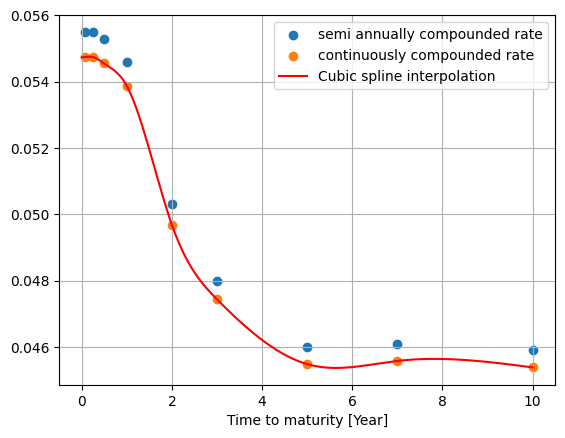

In [140]:
plt.scatter(yield_curves['T[years]'], yield_curves['Spot rate (semi annually compounded)'], label = 'semi annually compounded rate')
plt.scatter(yield_curves['T[years]'], yield_curves['Spot rate (continuously compounded)'], label = 'continuously compounded rate')
plt.plot(cubic_spline_T, interpolated_yield, c='r', label='Cubic spline interpolation')
plt.xlabel('Time to maturity [Year]')
plt.legend()
plt.grid()
plt.show()

# Data cleaning
### Step1: Read SPX index data (European option data) obtained from OptionDX. (reference: https://www.optionsdx.com/)
### Step2: Select only data in a day and remove options with time to maturity below 1 month. (in this case, 2023-09-29)
### Step3: Compute the middle prices for call and put prices.
### Step4: Trim data based on liquidity criteria 1. Bid price must be > 0, 2. Criteria recommendded by CME to avoid price anomaly due to liquidity issues. (reference: https://cdn.cboe.com/api/global/us_indices/governance/VIX_Methodology.pdf, page 7-8)

In [5]:
df = pd.read_csv('C:/min/coding_project/CQF_Optimal_Delta_Hedging_for_Options/data/spx_eod_202309.txt')
columns = ['QUOTE_DATE', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'DTE', 'C_DELTA', 'C_IV', 'C_BID', 'C_ASK',
           'P_DELTA', 'P_IV', 'P_BID', 'P_ASK', 'STRIKE']
df.columns = [i[2:-1] for i in df.columns]
df = df[columns]
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])
df = df[(df['QUOTE_DATE']=='2023-09-29')&(df['DTE']>=30)]
df['C_PRICE'] = (df['C_BID'] + df['C_ASK'])/2
df['P_PRICE'] = (df['P_BID'] + df['P_ASK'])/2
df['DTE'] = np.around(df['DTE'], -1)
df['T'] = df['DTE']/365
df = df.sort_values(['T','STRIKE'])
df

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_DELTA,C_IV,C_BID,C_ASK,P_DELTA,P_IV,P_BID,P_ASK,STRIKE,C_PRICE,P_PRICE,T
163754,2023-09-29,4286.6,2023-10-30,30.0,1.00000,0.000400,3087.6,3095.8,-0.00032,1.244200,0.0,0.10,1200.0,3091.70,0.050,0.082192
163839,2023-09-29,4286.6,2023-10-31,30.0,1.00000,0.000000,3087.7,3096.5,-0.00027,1.171860,0.0,0.05,1200.0,3092.10,0.025,0.082192
164183,2023-09-29,4286.6,2023-11-01,30.0,1.00000,-0.000210,3087.9,3096.8,-0.00038,1.154990,0.0,0.05,1200.0,3092.35,0.025,0.082192
164255,2023-09-29,4286.6,2023-11-02,30.0,0.99819,1.536910,3089.3,3098.1,-0.00027,1.189860,0.0,0.10,1200.0,3093.70,0.050,0.082192
163755,2023-09-29,4286.6,2023-10-30,30.0,1.00000,-0.000220,2888.5,2897.3,0.00000,1.096700,0.0,0.10,1400.0,2892.90,0.050,0.082192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168842,2023-09-29,4286.6,2028-12-15,1900.0,0.05527,0.131390,6.3,48.4,-1.00000,,2880.7,3072.60,8800.0,27.35,2976.650,5.205479
168843,2023-09-29,4286.6,2028-12-15,1900.0,0.04523,0.134570,5.0,39.1,-1.00000,,3186.3,3378.20,9200.0,22.05,3282.250,5.205479
168844,2023-09-29,4286.6,2028-12-15,1900.0,0.03814,0.139090,5.0,32.7,-1.00000,,3494.7,3686.60,9600.0,18.85,3590.650,5.205479
168845,2023-09-29,4286.6,2028-12-15,1900.0,0.02680,0.137080,3.1,22.3,-1.00000,,3805.0,3996.90,10000.0,12.70,3900.950,5.205479


In [6]:
clean_signal_put = []
clean_signal_call = []

for T in df['T'].unique():
    tmp_df = df[df['T'] == T].copy().sort_values(['STRIKE'])
    
    found_0_bid_call = []
    found_2_consecutive_0_bid = False
    is_last_0_bid = False
    for i in tmp_df.itertuples():
        if found_2_consecutive_0_bid:
            found_0_bid_call.append(0)
        else:
            if i.C_BID == 0:
                if is_last_0_bid:
                    found_2_consecutive_0_bid = True
                is_last_0_bid = True
                found_0_bid_call.append(0)
            else:
                is_last_0_bid = False
                found_0_bid_call.append(1)
    
    tmp_df = df[df['T'] == T].copy().sort_values(['STRIKE'], ascending=False)
    
    found_0_bid_put = []
    found_2_consecutive_0_bid = False
    is_last_0_bid = False
    for i in tmp_df.itertuples():
        if found_2_consecutive_0_bid:
            found_0_bid_put.append(0)
        else:
            if i.P_BID == 0:
                if is_last_0_bid:
                    found_2_consecutive_0_bid = True
                is_last_0_bid = True
                found_0_bid_put.append(0)
            else:
                is_last_0_bid = False
                found_0_bid_put.append(1)
    clean_signal_put += found_0_bid_put[::-1]
    clean_signal_call += found_0_bid_call

In [7]:
df['clean_signal_put'] = clean_signal_put
df['clean_signal_call'] = clean_signal_call
df['clean_signal_put_and_call'] = df.apply(lambda x: 1 if x['clean_signal_put']>=1 and x['clean_signal_call']>=1 else 0, axis=1)
df = df[df['clean_signal_put_and_call'] == 1].copy()
df['r'] = df['T'].apply(cubic_spline_function)
df = df.drop(['P_BID', 'P_ASK', 'C_BID', 'C_ASK', 'C_IV', 'P_IV'], axis=1)
df

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_DELTA,P_DELTA,STRIKE,C_PRICE,P_PRICE,T,clean_signal_put,clean_signal_call,clean_signal_put_and_call,r
164259,2023-09-29,4286.6,2023-11-02,30.0,0.99737,0.00000,2000.0,2297.65,0.100,0.082192,1,1,1,0.054744
163846,2023-09-29,4286.6,2023-10-31,30.0,1.00000,-0.00004,2100.0,2196.20,0.100,0.082192,1,1,1,0.054744
163759,2023-09-29,4286.6,2023-10-30,30.0,1.00000,-0.00004,2200.0,2096.50,0.125,0.082192,1,1,1,0.054744
163847,2023-09-29,4286.6,2023-10-31,30.0,1.00000,-0.00071,2200.0,2096.70,0.125,0.082192,1,1,1,0.054744
164188,2023-09-29,4286.6,2023-11-01,30.0,1.00000,-0.00080,2200.0,2097.15,0.125,0.082192,1,1,1,0.054744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168841,2023-09-29,4286.6,2028-12-15,1900.0,0.08352,-1.00000,8400.0,46.25,2675.250,5.205479,1,1,1,0.045414
168842,2023-09-29,4286.6,2028-12-15,1900.0,0.05527,-1.00000,8800.0,27.35,2976.650,5.205479,1,1,1,0.045414
168843,2023-09-29,4286.6,2028-12-15,1900.0,0.04523,-1.00000,9200.0,22.05,3282.250,5.205479,1,1,1,0.045414
168844,2023-09-29,4286.6,2028-12-15,1900.0,0.03814,-1.00000,9600.0,18.85,3590.650,5.205479,1,1,1,0.045414


# Obtain raw implied volatility
### Step1: Compute the implied continuous dividend yield using Put-Call parity to ensure no arbitrage pricing. (reference: https://web.ma.utexas.edu/users/mcudina/m339d_lecture6.pdf)
### Step2: Apply bisection method (root finding technique) to back out the implied volatility by using BSM analytical solutions for both put and call sides

#### As we already ensure the no arbitrage condition using Put-Call parity, the IV obtained from both put and call sides should be exactly the same, which is true as we can see in the plots and dataframe values below.

In [21]:
def get_dividend_yield_from_put_call_parity(S, put_price, call_price, strike, r, T):
    q = np.log(S / (call_price - put_price + strike * np.exp(-r*T))) / T
    return q

def cal_BSM_call_option(s, k, q, r, sigma, T):
    d1 = (np.log(s/k) + ((r - q) + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return s * np.exp(-q * T) * norm.cdf(d1) - k * np.exp(-r * T) * norm.cdf(d2)

def cal_BSM_put_option(s, k, q, r, sigma, T):
    d1 = (np.log(s/k) + ((r - q) + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return k * np.exp(-r * T) * norm.cdf(-d2) - s * np.exp(-q * T) * norm.cdf(-d1)

def get_implied_volatility(x):
    global cubic_spline_function
    S = x['UNDERLYING_LAST']
    call_price = x['C_PRICE']
    put_price = x['P_PRICE']
    T = x['T']
    r = x['r']
    strike = x['STRIKE']
    q = get_dividend_yield_from_put_call_parity(S, put_price, call_price, strike, r, T)
    print('q:', q)
    try:
        call_iv = optimize.bisect(lambda sigma : (cal_BSM_call_option(S, strike, q, r, sigma, T) - call_price), 0.05, 1)
    except:
        call_iv = -1
    try:
        put_iv = optimize.bisect(lambda sigma : (cal_BSM_put_option(S, strike, q, r, sigma, T) - put_price), 0.05, 1)
    except:
        put_iv = -1
    return call_iv, put_iv

In [23]:
tmp_ivs = df.apply(get_implied_volatility, axis=1)
df['call_iv'] = [i[0] for i in tmp_ivs]
df['put_iv'] = [i[1] for i in tmp_ivs]

q: -0.005593629246205837
q: -0.00020515045711414357
q: 0.00028854284928606707
q: -0.0002791178318170909
q: -0.0015562575354511944
q: -0.005670573755278593
q: -0.00035308475683717137
q: 0.0021275993657972367
q: -0.0004270512321796594
q: -0.001562279341882473
q: -0.005960288053222169
q: -0.00043006241522625674
q: 0.0018376993194020202
q: -0.0004330735975295024
q: -0.001710197141318239
q: -0.0061081523932943185
q: -0.00036362395831188475
q: 0.0019766249209117125
q: -0.0003666351570575443
q: 0.0021155521087676413
q: -0.00029718513859492557
q: 0.00041239379747389177
q: -0.006397856271867105
q: -0.0003696463550558153
q: -0.00044210713996156183
q: -0.0003726575523107496
q: 0.0005482916997376182
q: -0.00044511831928328887
q: 0.000761175828496157
q: -0.006403875682457188
q: 0.0011854494696943456
q: 0.0012549083483850258
q: 0.0013243676236192755
q: 0.0003293885530433918
q: 0.0013228618152536908
q: -0.0019411028981789595
q: -0.006693572519649447
q: 0.0014285572799906312
q: 0.001321356007074512
q:

q: 0.002260036818536643
q: 0.004169148898999253
q: 0.0024657031095526873
q: 0.00033673120600795673
q: -0.004771281929620419
q: 0.00409091846992366
q: 0.0018197250150283181
q: 0.0002585254150331675
q: -0.007260811462563873
q: 0.00415465130015039
q: 0.0024512075403633755
q: 0.00032223817308723516
q: -0.004927627355971272
q: 0.0027988240002318697
q: 0.0014431477739711663
q: 0.0017270149846064856
q: 0.0013649348707891248
q: 0.003557816420766307
q: 0.0021383330227512584
q: -0.00694244116087765
q: -0.007793416360284807
q: 0.003195681818994466
q: 0.0034013639269722708
q: 0.0022657785620207533
q: 0.0019036824144799862
q: 0.0033868672429755516
q: 0.003102961303223186
q: 0.0011795224471821053
q: 0.0030247377293089704
q: 0.001243240028380144
q: 0.003230416947404182
q: 0.0017327564765539367
q: 0.0032159204670925653
q: 0.0036417858150033797
q: 0.001576327449489644
q: 0.0012142518200443156
q: -0.001624002685944637
q: -0.00020495819687396473
q: -0.007724008722713738
q: 0.0018457029196639416
q: 0.0030

q: 0.009080426754109246
q: 0.008931075479382718
q: 0.007439629505821531
q: 0.006374460181134877
q: 0.0029667536540461566
q: 0.008888266089145287
q: 0.007609874899003889
q: 0.006331662783396197
q: 0.0029239722358584525
q: 0.009058538511977328
q: 0.007567071706633078
q: 0.006395375924703806
q: 0.00277472169063264
q: 0.009015728523749657
q: 0.00897291873636329
q: 0.007587990184012582
q: 0.006309781133753151
q: 0.002582693768370104
q: 0.008930109149817948
q: 0.008887299764111331
q: 0.00760890870934306
q: 0.005904665854635742
q: 0.002497134733696022
q: 0.008844490579243153
q: 0.008908221268250445
q: 0.007523302534444912
q: 0.00635161237232165
q: 0.0027309754994441883
q: 0.007373976743198576
q: 0.008929142820355288
q: 0.006053001578197382
q: 0.00647903937839135
q: 0.0028583519544315076
q: 0.008886333439181507
q: 0.006010205688107555
q: 0.006329730674839873
q: 0.0014315766251276403
q: 0.008950064420429471
q: 0.007671664573062259
q: 0.006393443802656268
q: 0.0017081656035952313
q: 0.0075223363

q: 0.010408440556460197
q: 0.0098752822253212
q: 0.009853729404996034
q: 0.010258508254714192
q: 0.009981153106527611
q: 0.010300669220386386
q: 0.009938046904351412
q: 0.009916493898717894
q: 0.009809676890086343
q: 0.009020794740654979
q: 0.010448708091820651
q: 0.010341883295354638
q: 0.010405599128670878
q: 0.008764089226220781
q: 0.010277220892340767
q: 0.008891493909006223
q: 0.010234112941868592
q: 0.010297827834547192
q: 0.008997350523324465
q: 0.008805294626909207
q: 0.010062630783396136
q: 0.010211611944788195
q: 0.010275326641075912
q: 0.009656915749131809
q: 0.01040275770198984
q: 0.010381203324270368
q: 0.010359649010193664
q: 0.010338094759758863
q: 0.010231271581935054
q: 0.010550798643739555
q: 0.010614516300545154
q: 0.00931398257584304
q: 0.009377689438033101
q: 0.00841835733743883
q: 0.010528296670510265
q: 0.010336200492697427
q: 0.010399916276413845
q: 0.010463632616258002
q: 0.010442078058795743
q: 0.009482606080186506
q: 0.009631575404561657
q: 0.0104626854663773

q: 0.009273908879525459
q: 0.008840140888677767
q: 0.008903813919447253
q: 0.008683245321898894
q: 0.008107413409294932
q: 0.009023773704135157
q: 0.00915851270726484
q: 0.00865369396088847
q: 0.009072671976748546
q: 0.008638918334215465
q: 0.008844709198020441
q: 0.008979444235087992
q: 0.008758872895378281
q: 0.009106793879287815
q: 0.009810084770519424
q: 0.008878829821918318
q: 0.008658262130219786
q: 0.008792993037832384
q: 0.009069852128505198
q: 0.008707157464901747
q: 0.008912950637194422
q: 0.008905562504515482
q: 0.00889817438080813
q: 0.009032910602054165
q: 0.008812337323772127
q: 0.009018134054285767
q: 0.00972141469508403
q: 0.008719113571649482
q: 0.008640666843143638
q: 0.008775397361060566
q: 0.0087680093954365
q: 0.008760621438784833
q: 0.008753233491102914
q: 0.009598621059312121
q: 0.009591232093847532
q: 0.009015314231322003
q: 0.008723681790107296
q: 0.007899166823345767
q: 0.008708905993443261
q: 0.008701518108568323
q: 0.008729659856782515
q: 0.00875780173518212

q: 0.012761268161098203
q: 0.012771560003804859
q: 0.012812727606787413
q: 0.010036537193306298
q: 0.012888963800877402
q: 0.011659740696028738
q: 0.012698361008393496
q: 0.012002741604845144
q: 0.012908015700262482
q: 0.011732142342235487
q: 0.010103192200386963
q: 0.010072710308665855
q: 0.013110047149447225
q: 0.012892750660296477
q: 0.012835565999786934
q: 0.012858433899503287
q: 0.01285461767619606
q: 0.012877485671403805
q: 0.012869853196108793
q: 0.010149551863326762
q: 0.010037216112895483
q: 0.009830042689762805
q: 0.009726459946767376
q: 0.009670297541954575
q: 0.009614135914882681
q: 0.00957201520495779
q: 0.009605391999311269
q: 0.013700303471727371
q: 0.009421948097496063
q: 0.009294668918593055
q: 0.009262219023087787
q: 0.009348303168012167
q: 0.00910249623940132
q: 0.009027008533679787
q: 0.009022637206424383
q: 0.00894715098712192
q: 0.008990189487455986
q: 0.009199168665517166
q: 0.009787495592738902
q: 0.008811144504789988
q: 0.00973133234268727
q: 0.0088024023203208

q: 0.00725951468138028
q: 0.007291813778792022
q: 0.00727672286436785
q: 0.007261632006097537
q: 0.007222846453442633
q: 0.007215301117525407
q: 0.007231450458015538
q: 0.007216359768203726
q: 0.007248658521923167
q: 0.007233567768080164
q: 0.007218477070390714
q: 0.007187237200112447
q: 0.007155997570473928
q: 0.0071882958434659255
q: 0.007173205314231358
q: 0.007121447529997938
q: 0.007117078256189928
q: 0.007065321188251846
q: 0.007013564780829582
q: 0.007032889125551585
q: 0.006981133132018038
q: 0.006929377798974249
q: 0.006849561545571468
q: 0.010509189700189112
q: 0.010273105993490968
q: 0.010134093937487924
q: 0.009859217394949141
q: 0.009750901054463168
q: 0.009933726718286722
q: 0.009864227070934617
q: 0.009794728879228934
q: 0.008657916341392445
q: 0.009306403031480632
q: 0.009586243037381426
q: 0.009289501079856861
q: 0.008410699334306633
q: 0.008385665775464611
q: 0.008341231579260608
q: 0.009111719447251834
q: 0.009280737558446935
q: 0.008207932560680262
q: 0.008990908465

q: 0.00786031323788965
q: 0.007888137531655194
q: 0.007915962079952758
q: 0.008078329463352383
q: 0.0070669559946616
q: 0.006980345826130435
q: 0.007818419952466748
q: 0.007134918693422273
q: 0.007162736352247844
q: 0.00696944108941527
q: 0.007629667586929279
q: 0.006938464658781455
q: 0.00784766728053833
q: 0.005955276686600562
q: 0.006907488543609979
q: 0.007532134639941176
q: 0.006912072030721843
q: 0.007501152478317363
q: 0.006881096184327827
q: 0.0068377934378478535
q: 0.006936727113834911
q: 0.006921239025664847
q: 0.007012431149491587
q: 0.006961382396799542
q: 0.007550472395350792
q: 0.00686703133812024
q: 0.007712820269176377
q: 0.006843799767763894
q: 0.006828312152768244
q: 0.007630776278497334
q: 0.007721989677741548
q: 0.007429705941906626
q: 0.00788434670674412
q: 0.00779771326056284
q: 0.007853360957328914
q: 0.007837868200990257
q: 0.007822375523564353
q: 0.007850199470287218
q: 0.007735743842417534
q: 0.007506845506505338
q: 0.007775897964752293
q: 0.007795975224703090

q: 0.008633682886751906
q: 0.008999512793542127
q: 0.00895340904137869
q: 0.00887679182641617
q: 0.008510317550046987
q: 0.008387950385550843
q: 0.008280842482148564
q: 0.008173738978824147
q: 0.008112397205130203
q: 0.010190696154565197
q: 0.010099449119561489
q: 0.009993955546940127
q: 0.009874217289685388
q: 0.00978298212126013
q: 0.009620510677432524
q: 0.009856992606343032
q: 0.009480803146639967
q: 0.009788514026854692
q: 0.008871027917949885
q: 0.008267143240059201
q: 0.008717120926389809
q: 0.008950697717779656
q: 0.008899410075136008
q: 0.008933584267308418
q: 0.009281145120049225
q: 0.008887983886094932
q: 0.008836697565246835
q: 0.008785412325315392
q: 0.008848071166866265
q: 0.008825271670679587
q: 0.008688531522638028
q: 0.009093035275828412
q: 0.008529002337819667
q: 0.008506205830988501
q: 0.009053119193132262
q: 0.00891636624105524
q: 0.009004672980104477
q: 0.009036005022325563
q: 0.009010360166847612
q: 0.009013203765204172
q: 0.008674210775293532
q: 0.008933427221997

q: 0.009339027826881422
q: 0.009416758688262514
q: 0.009755908155135896
q: 0.009429647746841626
q: 0.009745032768994822
q: 0.009846546707507488
q: 0.009662859692973265
q: 0.00936037606841803
q: 0.009533161433272935
q: 0.00977726078602169
q: 0.009498523530129694
q: 0.009576260505821851
q: 0.009487649524302793
q: 0.009470330887477915
q: 0.009334200684418698
q: 0.00926936102741107
q: 0.008016864955044547
q: 0.009282249149124917
q: 0.009027337836244294
q: 0.009271376303009695
q: 0.009301581485285924
q: 0.009284264437531817
q: 0.009266947537662945
q: 0.009368437544654048
q: 0.009065997832590107
q: 0.009048682796574496
q: 0.00884131202850396
q: 0.0092991679571886
q: 0.00883044154640884
q: 0.009050697852867457
q: 0.00905714120863469
q: 0.009134861264992083
q: 0.008879968478358525
q: 0.008767632770227378
q: 0.00905915627333215
q: 0.008780517703448287
q: 0.008786960200761768
q: 0.008935939590651214
q: 0.009037413031676815
q: 0.008996340412608135
q: 0.008717710473575268
q: 0.008944397532441252
q

q: 0.01072924611641191
q: 0.010427293978566473
q: 0.010676653501229236
q: 0.010184048655240384
q: 0.010735316802978291
q: 0.010115590372914643
q: 0.011509435866063851
q: 0.010142454768072722
q: 0.01144091043442389
q: 0.010073998591991077
q: 0.011420093986266061
q: 0.010148522820134079
q: 0.011494692460304002
q: 0.010286604820515934
q: 0.011521584275638378
q: 0.010106930025996714
q: 0.011437155816688018
q: 0.01002258986879569
q: 0.011336831398899933
q: 0.010367209804113419
q: 0.011316016553325762
q: 0.0102987422460451
q: 0.011470120474682583
q: 0.010071406217435644
q: 0.011385695229687064
q: 0.009574114355881413
q: 0.011937453711661558
q: 0.010315789929576522
q: 0.011359965670769228
q: 0.00983429155828941
q: 0.011227846895062907
q: 0.01029008072572855
q: 0.011302434760900048
q: 0.010158066465225192
q: 0.01142473241610308
q: 0.010216707266836414
q: 0.011324408920249189
q: 0.009830541400101683
q: 0.01135129734838518
q: 0.00996859092311704
q: 0.010948910619330137
q: 0.010201977952864025
q:

q: 0.010283743211080682
q: 0.010312896604010002
q: 0.010301774284402333
q: 0.010290652073248347
q: 0.010306380260675402
q: 0.010254983199146105
q: 0.010297560977263453
q: 0.010205891241063641
q: 0.010167922301834232
q: 0.010223921083728667
q: 0.010159104088906596
q: 0.010161406786676461
q: 0.010150285944151943
q: 0.010233132426131315
q: 0.010101198491885868
q: 0.010116924067118591
q: 0.009998425172945097
q: 0.009920200153075234
q: 0.009976186774117215
q: 0.010072443082254728
q: 0.010007634694483833
q: 0.009996515351094953
q: 0.009904869805161793
q: 0.009960855673713027
q: 0.009882633230260186
q: 0.00996546027352006
q: 0.009954341341257547
q: 0.010010329638157347
q: 0.009972367208084061
q: 0.010001512643495325
q: 0.010003815023141205
q: 0.010006117407434338
q: 0.009968155117550313
q: 0.009661808147791823
q: 0.010348620220218797
q: 0.009706665568860996
q: 0.00976264170946065
q: 0.009228312588932919
q: 0.00919037617670037
q: 0.00966220057967039
q: 0.0097047562354599
q: 0.00963996873507505

q: 0.009864008918592192
q: 0.009798535057253949
q: 0.009789656980717158
q: 0.009860011706679689
q: 0.009862452450888484
q: 0.009796978695642443
q: 0.009414660113629004
q: 0.009609460532658329
q: 0.00958039175760859
q: 0.00938160201170068
q: 0.008990577999830019
q: 0.008950219170924836
q: 0.009373611618530562
q: 0.009439940412138534
q: 0.009393127860447062
q: 0.009120076739333925
q: 0.009175076602182069
q: 0.009064514357622504
q: 0.008948310477334347
q: 0.00870774818491415
q: 0.00858593522753287
q: 0.00847544077192841
q: 0.012432191058308747
q: 0.012355586998724305
q: 0.012533571169450489
q: 0.012250424080144262
q: 0.012169035160019463
q: 0.012097257519697063
q: 0.012025486230630177
q: 0.012068947133174596
q: 0.01205479231045081
q: 0.011819810289335122
q: 0.011767261846747945
q: 0.012002727215918227
q: 0.011950166921968526
q: 0.011899885611531894
q: 0.011567587119080017
q: 0.011542457929630962
q: 0.011824469489715666
q: 0.011501797952774628
q: 0.011467075032139225
q: 0.01175865948524413

q: 0.010889306287872354
q: 0.010537562645517548
q: 0.010325898361267814
q: 0.010641433317754082
q: 0.008363476926941473
q: 0.008286652966491117
q: 0.008316909915021953
q: 0.008133044326669643
q: 0.0016646349836003558
q: 0.01048489906369951
q: 0.009800303487329213
q: 0.009906813514597431
q: 0.010621045280219876
q: 0.010442554127948837
q: 0.010296398080556666
q: 0.010424541441017713
q: 0.010794915920204168
q: 0.01091781609325655
q: 0.001722187952030499
q: 0.01090516923441299
q: 0.010888076482467864
q: 0.010833294740485647
q: 0.009778326564729552
q: 0.010573060824864101
q: 0.010529077985910506
q: 0.010474339867503853
q: 0.0104626429996247
q: 0.010386397748691068
q: 0.010342433124465833
q: 0.01069121033461596
q: 0.01005560802143966
q: 0.010232071790127042
q: 0.010155865538977618
q: 0.011010510014546674
q: 0.010761878099502036
q: 0.010938618717898727
q: 0.01114236639417258
q: 0.010942126913747723
q: 0.012959804500823086
q: 0.011003939215804469
q: 0.013242824575057878
q: 0.014688492068794093

In [25]:
df

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_DELTA,P_DELTA,STRIKE,C_PRICE,P_PRICE,T,clean_signal_put,clean_signal_call,clean_signal_put_and_call,r,call_iv,put_iv
164259,2023-09-29,4286.6,2023-11-02,30.0,0.99737,0.00000,2000.0,2297.65,0.100,0.082192,1,1,1,0.054744,0.820247,0.820247
163846,2023-09-29,4286.6,2023-10-31,30.0,1.00000,-0.00004,2100.0,2196.20,0.100,0.082192,1,1,1,0.054744,0.770020,0.770020
163759,2023-09-29,4286.6,2023-10-30,30.0,1.00000,-0.00004,2200.0,2096.50,0.125,0.082192,1,1,1,0.054744,0.735003,0.735003
163847,2023-09-29,4286.6,2023-10-31,30.0,1.00000,-0.00071,2200.0,2096.70,0.125,0.082192,1,1,1,0.054744,0.735049,0.735049
164188,2023-09-29,4286.6,2023-11-01,30.0,1.00000,-0.00080,2200.0,2097.15,0.125,0.082192,1,1,1,0.054744,0.735152,0.735152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168841,2023-09-29,4286.6,2028-12-15,1900.0,0.08352,-1.00000,8400.0,46.25,2675.250,5.205479,1,1,1,0.045414,0.144776,0.144776
168842,2023-09-29,4286.6,2028-12-15,1900.0,0.05527,-1.00000,8800.0,27.35,2976.650,5.205479,1,1,1,0.045414,0.139060,0.139060
168843,2023-09-29,4286.6,2028-12-15,1900.0,0.04523,-1.00000,9200.0,22.05,3282.250,5.205479,1,1,1,0.045414,0.141644,0.141644
168844,2023-09-29,4286.6,2028-12-15,1900.0,0.03814,-1.00000,9600.0,18.85,3590.650,5.205479,1,1,1,0.045414,0.145307,0.145307


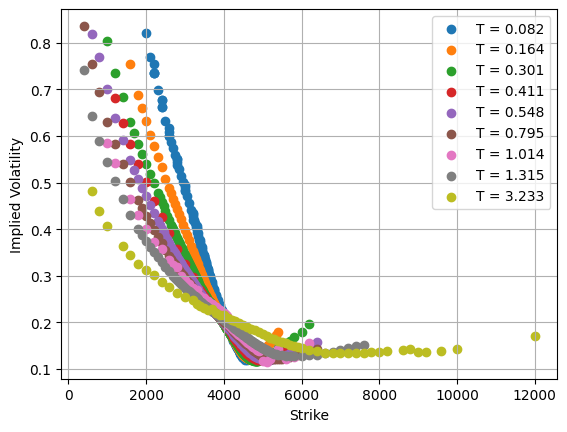

In [141]:
for T in [i for ind, i in enumerate(df['T'].unique()) if ind % 3 == 0]:
    tmp_df = df[df['T']==T].copy()
    plt.scatter(tmp_df['STRIKE'], tmp_df['call_iv'], label = 'T = ' + str(np.around(T, 3)))
plt.legend()
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.grid()
plt.show()

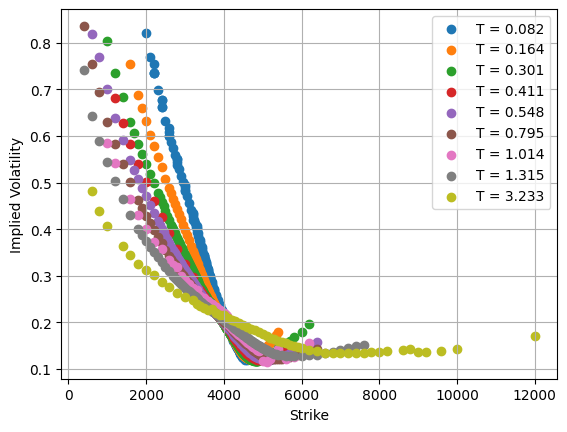

In [142]:
for T in [i for ind, i in enumerate(df['T'].unique()) if ind % 3 == 0]:
    tmp_df = df[df['T']==T].copy()
    plt.scatter(tmp_df['STRIKE'], tmp_df['put_iv'], label = 'T = ' + str(np.around(T, 3)))
plt.legend()
plt.grid()
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.show()

# SVI fitting with non-linear optimization (Nelder-Mead algorithm) with time to maturity = 3.23 years
### Step1: Compute log-strike price (moneyness) as we use log-strike prices instead of the raw strike prices when fitting SVI.
### Step2: Apply Nelder-Mead algorithm to minimize the differences between the implied volatility from SVI and raw data to find optimal parameters (a, b, rho, m, sigma).

In [109]:
tmp_df['log_strike'] = np.log(tmp_df['STRIKE']/ (tmp_df['UNDERLYING_LAST'] * np.exp(tmp_df['r'] * tmp_df['T'])))
tmp_df

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_DELTA,P_DELTA,STRIKE,C_PRICE,P_PRICE,T,clean_signal_put,clean_signal_call,clean_signal_put_and_call,r,call_iv,put_iv,log_strike
168679,2023-09-29,4286.6,2026-12-18,1180.0,1.00000,-0.00175,600.0,3649.450,3.075,3.232877,1,1,1,0.047118,0.481605,0.481605,-2.118645
168680,2023-09-29,4286.6,2026-12-18,1180.0,1.00000,-0.00399,800.0,3425.900,4.950,3.232877,1,1,1,0.047118,0.437978,0.437978,-1.830963
168681,2023-09-29,4286.6,2026-12-18,1180.0,1.00000,-0.00557,1000.0,3257.650,7.500,3.232877,1,1,1,0.047118,0.406547,0.406547,-1.607820
168683,2023-09-29,4286.6,2026-12-18,1180.0,0.93713,-0.01225,1400.0,2976.400,15.400,3.232877,1,1,1,0.047118,0.363147,0.363147,-1.271347
168684,2023-09-29,4286.6,2026-12-18,1180.0,0.92368,-0.01737,1600.0,2811.400,21.100,3.232877,1,1,1,0.047118,0.345096,0.345096,-1.137816
168685,2023-09-29,4286.6,2026-12-18,1180.0,0.92412,-0.02419,1800.0,2587.950,28.250,3.232877,1,1,1,0.047118,0.325740,0.325740,-1.020033
168686,2023-09-29,4286.6,2026-12-18,1180.0,0.90859,-0.03245,2000.0,2431.700,37.200,3.232877,1,1,1,0.047118,0.311834,0.311834,-0.914672
168687,2023-09-29,4286.6,2026-12-18,1180.0,0.88265,-0.04258,2200.0,2323.300,47.900,3.232877,1,1,1,0.047118,0.301775,0.301775,-0.819362
168688,2023-09-29,4286.6,2026-12-18,1180.0,0.88347,-0.05378,2400.0,2107.100,60.700,3.232877,1,1,1,0.047118,0.285686,0.285686,-0.732351
168689,2023-09-29,4286.6,2026-12-18,1180.0,0.85335,-0.06769,2600.0,2008.750,74.350,3.232877,1,1,1,0.047118,0.276554,0.276554,-0.652308


In [124]:
def SVI_fitting(iv_vector, strike_vector, T):
    def cal_SVI_error(x):
        nonlocal T, iv_vector, strike_vector
        a, b, rho, m, sigma = x
        if a + sigma * ( 1 - rho **2) ** 0.5 < 0:
            return 10000
        w = a + b * (rho * (strike_vector - m) + ((strike_vector - m)**2 + sigma**2)**0.5)
        if min(w) < 0:#total variance will never be less than 0!
            return 10000
        return np.mean(np.abs((w/T)**0.5 - iv_vector))
    initial_x = np.array([0.1,0.1,0.2, 0., 0.2])
    x = minimize(cal_SVI_error, 
                 initial_x,
                 bounds=[(-np.inf, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (0, np.inf)])
    return x

In [125]:
out = SVI_fitting(tmp_df['call_iv'].values, tmp_df['log_strike'].values, tmp_df['T'].values)

# Check if the optimization ended successfully.
### We got optimal parameters as shown below.
#### a = 0.0771, b = 0.2562, rho = -0.1716, m = 0.3342, sigma = 0.5272

In [126]:
out

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.003266271971896288
        x: [-7.710e-02  2.562e-01 -1.716e-01  3.342e-01  5.272e-01]
      nit: 33
      jac: [-3.007e-02 -7.725e-03 -4.114e-03  1.620e-03 -9.278e-03]
     nfev: 438
     njev: 73
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [128]:
def cal_SVI_IV(a, b, rho, m, sigma, T, strike_vector):
    return ((a + b * (rho * (strike_vector - m) + ((strike_vector - m)**2 + sigma**2)**0.5)) / T)**0.5

In [129]:
a, b, rho, m, sigma = out.x

In [132]:
SVI_iv = cal_SVI_IV(a, b, rho, m, sigma, T, tmp_df['log_strike'].values)

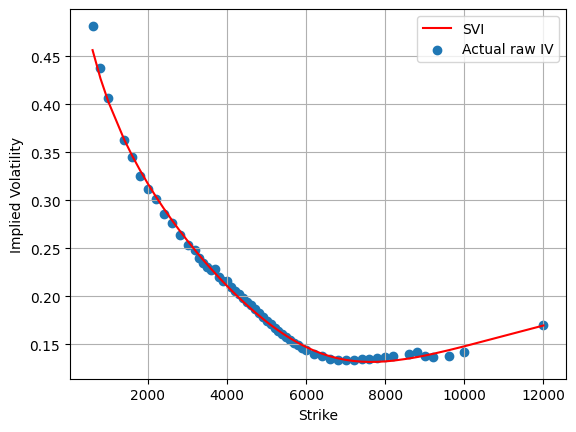

In [143]:
plt.plot(tmp_df['STRIKE'].values, SVI_iv, label='SVI', c='r')
plt.scatter(tmp_df['STRIKE'].values, tmp_df['call_iv'].values, label='Actual raw IV')
plt.legend()
plt.ylabel('Implied Volatility')
plt.xlabel("Strike")
plt.grid()
plt.show()

## Answers to the questions

### Meaning of each parameters in SVI

a	This parameter controls the vertical shift of the total implied variance.

b	This parameter increases the slopes of both the put and call wings, tightening the smile.

rho	This parameter decreases (increases) the slope of the left(right) wing, a counter-clockwise rotation of the smile.

m	This parameter translates the smile to the right.

sigma	This parameter reduces the at-the-money (ATM) curvature of the smile.

Reference: https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/cfm-imperial-institute-of-quantitative-finance/events/distinguished-lectures/Gatheral-2nd-Lecture.pdf

### What kind of dynamics do you think the Heston model will give? Is it sticky strike, sticky delta ?

The dynamics that the Heston model gives are underlying asset and also the implied volatility dynamics. I think the Heston model is a sticky delta model as it gives SSR of around 0.

### What kind of dynamics do you think the local volatility model will give? Is it sticky strike, sticky delta or something else?

The dynamics that the Local volatility model gives is underlying asset dynamic with the assumption of deterministic volatility for each strike price and time to maturity. I think the Local volatility model is neither sticky strike nor delta as it gives SSR of around 2.0 which is far away from the empirical result with SSR of 1.5.